# Lab 05 assignment (20 pts)

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Introduction

### Objectives
* Continue to explore GeoPandas functionality
* Explore basic geometry operations (e.g., buffer, intersect, union)
* Explore spatial filtering and spatial joins
* Explore new visualization approaches (e.g., hexbin, interactive maps)

In order to cover some additional important vector concepts, let's use a power plants dataset, and also explore some King County census data in tandem with some toxic release data. 

### Instructions  
- For each question or task below, write some code in the empty cell and execute to preserve your output 
- If you are in the graduate section of the class, please complete the challenge questions
- Work together, consult resources we've discussed, post on slack!
- Remember, the lab assignment this week is broken into two notebooks!

## Part 0: Prepare data

In [1]:
!pip install -q censusdata

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import os
import contextily as ctx
import censusdata
import seaborn as sns
import requests
import zipfile
import shutil

### Load in the power plants data
* These data are a subset of a cool global power plant dataset:
  
Global Energy Observatory, Google, KTH Royal Institute of Technology in Stockholm, University of Groningen, World Resources Institute. 2018. Global Power Plant Database. Published on Resource Watch and Google Earth Engine; https://resourcewatch.org/ https://earthengine.google.com/ 
* For details about this dataset, including a key to the column names, see https://developers.google.com/earth-engine/datasets/catalog/WRI_GPPD_power_plants#table-schema 
* Load the power plants geojson file into a GeoDataFrame and check the crs 

In [3]:
# read in the data
pplant_fn = './data/conus_power_plants.geojson'
pplant_gdf = gpd.read_file(pplant_fn)
pplant_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# take a quick look
pplant_gdf.head()

,cap_year,capacitymw,comm_year,country,country_lg,fuel1,fuel2,fuel3,fuel4,gppd_idnr,...,gwh_2014,gwh_2015,gwh_2016,gwh_estimt,latitude,longitude,name,owner,source,geometry
0,0.0,149.0,1969.00000,USA,United States of America,Gas,None,None,None,USA0001233,...,0.0,0.0,-0.209,613.166810,37.7328,-99.9497,Fort Dodge,Sunflower Electric Power Corp,U.S. Energy Information Administration,POINT (-99.9497 37.7328)
1,0.0,730.2,2008.46946,USA,United States of America,Gas,None,None,None,USA0056502,...,0.0,0.0,333.957,3004.928891,38.4459,-96.0652,Emporia Energy Center,Westar Energy Inc,U.S. Energy Information Administration,POINT (-96.0652 38.4459)
2,0.0,11.0,1962.00000,USA,United States of America,Gas,None,None,None,USA0001332,...,0.0,0.0,0.005,45.267348,37.2354,-97.0110,West 14th Street,City of Winfield - (KS),U.S. Energy Information Administration,POINT (-97.011 37.2354)
3,0.0,228.0,1957.50000,USA,United States of America,Gas,None,None,None,USA0001242,...,0.0,0.0,75.912,938.268676,37.5967,-97.4136,Murray Gill,Kansas Gas & Electric Co,U.S. Energy Information Administration,POINT (-97.4136 37.5967)
4,0.0,43.7,1982.00000,USA,United States of America,Gas,None,None,None,USA0050169,...,0.0,0.0,0.000,179.834830,37.5813,-97.4241,Wichita Plant,Occidental Chemical Corporation,U.S. Energy Information Administration,POINT (-97.4241 37.5813)


### Now we'll read in the state polygons...

In [5]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
states_gdf

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."
5,0400000US08,08,Colorado,,103641.888,"POLYGON ((-106.19055 40.99761, -106.06118 40.9..."
6,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-71.79924 42.00806, -71.79792 41.935..."
7,0400000US10,10,Delaware,,1948.543,"MULTIPOLYGON (((-75.56493 39.58325, -75.57627 ..."
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.0386 38.79151, -77.0389 38.80081..."
9,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-82.82158 27.96444, -82.8298 2..."


#### *Limit states_gdf to the lower 48*

* We want to filter out Alaska, Puerto Rico, and Hawaii from this dataset
    * One possible approach would be to use boolean indexing on states_gdf, creating an index where states_gdf['NAME'] contains Alaska, Puero Rico, and Hawaii 
    * Then you could index back into states_gdf where your index is False

Hint: Check out the [.isin()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html) function

In [6]:
# STUDENT CODE HERE

#### *Create a quick plot of power plant capacity overlayed on top of the state polygons to verify everything looks good*
* Can re-use plotting code near the end of Lab04
* If plotting a variable that is highly skewed to one side, consider passing `norm=colors.LogNorm()` to your `plot()` function to create a logarithmic colorbar.
* Note that here we're plotting in WGS84, not a projected coordinate system. This will result in some distortions! 

In [7]:
# STUDENT CODE HERE

<img src="imgs/capacity_wgs84.png" width="1000">

### *Extract the MultiPolygon geometry object for Washington from your reprojected states GeoDataFrame*
* Use the state 'NAME' value to isolate the approprate GeoDataFrame record for Washington to create `wa_gdf`

In [8]:
# STUDENT CODE HERE

## Part 1: Geometric Operations for power plant points (4 pts)

#### *Clip the power plant points to Washington state polygon*
* You could do this in two steps:
    * Identify records from the power plants GeoDataFrame that `intersects` the WA state geometry
    * Extract those records and store in a new GeoDataFrame

In [9]:
# STUDENT CODE HERE

### Define an azimuthal equidistant projection for Washington State
* We're going to do calculations of distance in this section, so we need to use a projection that preserves distance
* Let's quickly define a custom Azimuthal Equidistant projection for our power plant points and polgyons 

In [10]:
ae_proj_str = f'+proj=aeqd +lat_0={wa_gdf.iloc[0].geometry.centroid.y:.2f} +lon_0={wa_gdf.iloc[0].geometry.centroid.x:.2f} +datum=WGS84 +units=m +no_defs'

In [11]:
pplant_gdf_wa = pplant_gdf_wa.to_crs(ae_proj_str)
wa_gdf = wa_gdf.to_crs(ae_proj_str)

#### *Compute some statistics for the WA state power plants*
* How many power plants are in WA state?
* What is median `capacitymw` capacity of WA state power plants in megawatts?

In [12]:
# STUDENT CODE HERE

There are 138 power plants in Washington state.


In [13]:
# STUDENT CODE HERE

#### *Plot the resulting points*
* Add the WA polygon outline
    * Note that you don't need/want to use the Polygon Geometry object here.  Remember, you have a GeoDataFrame containing just the WA geometry.  And you know how to plot GeoDataFrames.
* Add the WA state centroid you calculated earlier using a distinct marker style (e.g., `'*'` or `'x'`)
    * Can use simple matplotlib `plot` with the coordinates, or can use `wa_gdf.centroid.plot()`
* As above, consider passing `norm=colors.LogNorm()` to your `plot()` function to create a logarithmic colorbar.

In [14]:
# STUDENT CODE HERE

<img src="imgs/capacity_wa_aeqd.png" width="1000">

#### *Find the distance from the power plants to the WA state centroid*
* See the GeoDataFrame `distance` function
* Create a plot showing this distance for each power plant point.

In [15]:
c = wa_gdf.iloc[0].geometry.centroid

In [16]:
# STUDENT CODE HERE

In [17]:
# STUDENT CODE HERE

<img src="imgs/capacity_wa_distfromcentroid.png" width="1000">

#### *What is the distance between this point (point closest to the centroid) and the centroid in km?*

In [18]:
# STUDENT CODE HERE

#### *What is the `capacitymw` value of this point?*
* For this, we need to isolate the original GeoDataFrame record corresponding to the minimum distance
* We talked about `argmin` or `argmax` for NumPy arrays. For a DataFrame, we want to use the `idxmin()` method on the column or DataSeries containing the distance values, which should give us the index value: 
    * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html
    * Can then use the index value to locate the corresponding record in the GeoDataFrame with standard Pandas indexing: https://pandas.pydata.org/docs/user_guide/indexing.html

In [19]:
# STUDENT CODE HERE

In [20]:
# STUDENT CODE HERE

In [21]:
# STUDENT CODE HERE

The closest power plant to the centroid of Washington state has a capacity of 1299.6 MW.


#### *Challenge Question (GS required/UG +0.5): Which power plant is farthest from the WA state perimeter?*
* Note that this is different than the above calcuations for point to point distance, you're looking for point to polyline distance
* What is the distance in km?
* This should be pretty straightforward, combining elements from the above questions/demo
* This kind of calculation can be useful to consider distance from the coast and climatology (temperature, precipitation and other environmental variables) 

In [22]:
# STUDENT CODE HERE

In [23]:
# STUDENT CODE HERE

In [24]:
# STUDENT CODE HERE

<img src="imgs/capacity_wa_distfromborder.png" width="1000">

## Part 2: Aggregate power plants for state polygons and compute `capacitymw` statistics (3 pts)

OK, we computed some stats for power plants within WA state.  Now let's find the power plants that intersect **each** state polygon. 

Objectives:
1. Compute the total number of power plants and total `capacitymw` energy generation capacity for each state
2. Generate choropleth maps for both

One approach would be to loop through each state polygon, and do an intersection operation like we did for WA state above.  But this is inefficient, and doesn't scale well.  It is much more efficient to do a spatial join between the power plant points and the polygons with the intersection operator, then groupby and aggregate to compute the relevant statistics for each state.

You may have learned how to perform a join or spatial join in a GIS class, perhaps using ArcMap or QGIS here. Luckily, GeoPandas has you covered.

### First, let's define an Albers Equal Area projection for our data
* We're going to be doing area-based calculations in this section, so we need to use a projection that preserves area
* We need to project both the power plant points and the state polygons

In [25]:
# get extent and center coordinates
pplant_extent = pplant_gdf.total_bounds
pplant_center_x = (pplant_extent[0] + pplant_extent[2])/2
pplant_center_y = (pplant_extent[3] + pplant_extent[1])/2

In [26]:
# define proj string
aea_proj_str = f'+proj=aea +lat_1={pplant_extent[1]:.2f} +lat_2={pplant_extent[3]:.2f} +lat_0={pplant_center_y:.2f} +lon_0={pplant_center_x:.2f}'

In [27]:
# reproject 
pplant_gdf_aea = pplant_gdf.to_crs(aea_proj_str)
states_gdf_aea = states_gdf.to_crs(aea_proj_str)

Now we can get rolling with analysis! 
### Start with a spatial join between the power plant points and state polygons
* Start by reviewing the [Spatial Join documentation](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html)
* Use the geopandas [`sjoin` method](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins)

### Let's extract the columns that matter to us
* Since we only care about `capacitymw` values here let's create some smaller GeoDataFrames:
    * Extract the `['capacitymw', 'geometry']` columns from the power plant GeoDataFrame
    * Extract the `['NAME', 'geometry']` columns from the states GeoDataFrame

In [28]:
pplant_gdf_aea_lite = pplant_gdf_aea[['capacitymw', 'geometry']]
states_gdf_aea_lite = states_gdf_aea[['NAME','geometry']]

#### *Now try a spatial join between these two*
* Use the power plant points as the "left" GeoDataFrame and the States as the "right" GeoDataFrame
* Start by using default options (`op='intersects', how='inner'`)
* Note the output geometry type and columns

In [29]:
# STUDENT CODE HERE

,capacitymw,geometry,index_right,NAME
0,149.0,POINT (-373798.752 116463.932),16,Kansas
1,730.2,POINT (-38844.692 189244.381),16,Kansas
2,11.0,POINT (-121518.346 52569.772),16,Kansas
3,228.0,POINT (-155679.348 94157.393),16,Kansas
4,43.7,POINT (-156617.964 92425.8),16,Kansas
...,...,...,...,...
7863,1.3,POINT (1763173.316 1010517.952),45,Vermont
7864,1.8,POINT (1828872.636 991070.108),45,Vermont
7865,1.8,POINT (1783973.835 1092752.901),45,Vermont
7866,1.8,POINT (1787741.825 1101022.7),45,Vermont


#### *Now reverse the order of the two input GeoDataFrames*
* Use default options again

In [30]:
# STUDENT CODE HERE

#### *Which one makes more sense?*
* Remember, we're trying to add a State name to each power plant
* You'll need to decide which one to use moving forward 

In [31]:
# STUDENT CODE HERE

### Confidence check
* Run a `head` on our new GeoDataFrame
* For each power plant point, there should be a new column with the corresponding state NAME

In [32]:
# STUDENT CODE HERE

,capacitymw,geometry,index_right,NAME
0,149.0,POINT (-373798.752 116463.932),16,Kansas
1,730.2,POINT (-38844.692 189244.381),16,Kansas
2,11.0,POINT (-121518.346 52569.772),16,Kansas
3,228.0,POINT (-155679.348 94157.393),16,Kansas
4,43.7,POINT (-156617.964 92425.8),16,Kansas


### *Now aggregate by state `NAME`*
* Note: the GeoPandas doc example uses a `dissolve` operation here, which is a wrapper around the `groupby` and `agg` Pandas functions
    * https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
* But look at the geometry column for the points in your GeoDataFrame.  The `dissolve` is going to compute the union for the points in each state and return a `MultiPoint` Geometry for each state, which we don't really want/need.  It will also take longer to run.
* Instead, let's try a `groupby` operation for the `NAME` column, and then `agg` with a list of functions we care about: `['count', 'sum']` (statistics for point count and mean point elevation for each state)
    * We did this in Lab02!

In [33]:
# STUDENT CODE HERE

,count,sum
NAME,,
Alabama,71,31451.9
Arizona,121,32991.9
Arkansas,56,16341.8
California,1273,82100.4
Colorado,163,17838.5
Connecticut,94,7489.1
Delaware,25,3628.3
District of Columbia,2,24.9
Florida,148,66705.4


### Confidence check
* That groupby and agg should be pretty fast (~1-2 seconds)
* Check the `type()` of the output
* Since `groupby` and `agg` are Pandas operation, you should now have a new Pandas `DataFrame` (not a GeoPandas `GeoDataFrame`) with index of state names and columns for `count` and `mean` values in each state

In [34]:
# STUDENT CODE HERE

## Part 3: Plots! (2 pts)

* How are we going to visualize these data?
* We have `count` power plant points and `sum` of power plant capacity for each state!  Objective #1 complete!
* We now want to visualize these values, but we lost our state Polygon/MultiPolygon Geometry along the way
* No problem, we can combine our DataFrame with the original State GeoDataFrame
    * Can use `merge` to do an attribute join on the shared state `'NAME'` index for the two
        * Take a moment to review the `my_agg_df.merge?` options
        * In this case, we have a common `NAME` field, so we can use the `on='NAME'` here for attribute join
    * Careful about the order of the two inputs here (state GeoDataFrame and the DataFrame with your stats) - you want to preserve the index and geometry of the GeoDataFrame, adding the `count` and `mean` columns.
        * If you get it right, you should be able to `plot()` the GeoPandas GeoDataFrame and get a map.  If you got it backwards, the output of `plot()` will be a line plot for the regular Pandas DataFrame

#### *Combine `states_gdf_aea_lite` and `pplant_gdf_aea_states_agg`*

In [35]:
# STUDENT CODE HERE

,NAME,geometry,count,sum
0,Alabama,"MULTIPOLYGON (((708732.822 -707811.735, 712514...",71,31451.9
1,Arizona,"POLYGON ((-1465661.328 152092.001, -1465314.16...",121,32991.9
2,Arkansas,"POLYGON ((143568.999 -425106.846, 143453.305 -...",56,16341.8
3,California,"MULTIPOLYGON (((-2277167.082 437548.205, -2277...",1273,82100.4
4,Colorado,"POLYGON ((-869898.203 525860.898, -859309.622 ...",163,17838.5
5,Connecticut,"POLYGON ((1914586.875 827355.12, 1916674.15 81...",94,7489.1
6,Delaware,"MULTIPOLYGON (((1672374.733 490114.235, 167132...",25,3628.3
7,District of Columbia,"POLYGON ((1567915.217 377568.875, 1567691.059 ...",2,24.9
8,Florida,"MULTIPOLYGON (((1242485.092 -913944.857, 12416...",148,66705.4
9,Georgia,"POLYGON ((962929.008 -150182.712, 963044.303 -...",157,39580.0


#### *Create a choropleth map to visualize the count of power plants in each state*
* https://geopandas.readthedocs.io/en/latest/mapping.html#choropleth-maps

In [36]:
# STUDENT CODE HERE

<img src="imgs/count_states.png" width="1000">

#### *Create a choropleth map to visualize the total power plant capacity in megawatts in each state*

In [37]:
# STUDENT CODE HERE

<img src="imgs/capacity_states.png" width="1000">

## Part 4: Point density visualization: hexbin plots (2 pts)


OK, now we have statistics and plots for our existing polygons.  But what if we want to compute similar statistics for a regularly spaced grid of cells?  For our `count`, this will give us point density, allowing for better visualization of the spatial distribution.

We could define a set of adjacent rectangular polygons, and repeat our `sjoin`, `groupby`, `agg` sequence above.  Or we can use some existing matplotlib functionality, and create a hexbin plot!

Hexagonal cells are preferable over a standard square/rectangular grid for [various reasons]( https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-whyhexagons.htm), especially since [projection distortion impacts spatial binning.](https://www.tandfonline.com/doi/full/10.1080/15230406.2016.1180263)

Here are some resources on generating hexbins using Python and matplotlib:
* https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html
* http://darribas.org/gds15/content/labs/lab_09.html

*Note: an equal-area projection is always good idea for a hexbin plot.  Fortunately, we started with our AEA projection, so we're all set!*

#### *Create a hexbin that shows the number of power plants in each cell*
* Play around with the `gridsize` option to set the number of bins in each dimension (or specify the dimensions of your bins)
* Use the `mincnt` option to avoid plotting cells with 0 count
* Overlay the state polygons to help visualize
* Set your plot `xlim` and `ylim` to the power plant point bounds
* Can use linear color ramp with vmin and vmax options, or try a logarithmic color ramp, since we have a broad range of counts

In [38]:
# STUDENT CODE HERE

<img src="imgs/count_hexbin.png" width="1000">

#### *Create a second hexbin plot that shows the total energy generation capacity in each cell*
* See documentation for the `C` and `reduce_C_function` options

In [39]:
# STUDENT CODE HERE

<img src="imgs/capacity_hexbin.png" width="1000">

#### *Challenge question (GS required/UG +0.5): Generate a Kernel Density Estimator (KDE) plot using `seaborn`*
* This is another nice approach to estimate the point density on a continuous grid
* See motivation here for an explanation: https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation#Motivation
* Seaborn has a nice implementation for 2D data
    * https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot
    * https://seaborn.pydata.org/tutorial/distributions.html

In [40]:
# STUDENT CODE HERE

<img src="imgs/kdeplot.png" width="1000">

### Static plots with tiled basemaps using `contextily`
* Our state outlines provide some context for our plots, but what if we want a raster map background
* * Freely available tiled web maps are great: https://en.wikipedia.org/wiki/Tiled_web_map
* Can use the convenient `contextily` package for this: https://github.com/geopandas/contextily

#### *Plot the WA points using our custom projected coordinate system*
* Make sure to pass in the appropriate CRS object to `add_basemap` 
* For the particular basemap, try `ctx.providers.Esri.WorldImagery`, and then at least one additional different `ctx.provider`

In [41]:
# STUDENT CODE HERE

<img src="imgs/capacity_conus_basemap.png" width="1000">

#### *Repeat for WA state*
Thought question: Do you note anything about the relationship between power plant locations and rivers in Washington?

In [42]:
# STUDENT CODE HERE

<img src="imgs/capacity_wa_basemap.png" width="1000">

#### *Challenge Question (GS required/UG +0.5): Make a figure with choropleth maps showing total energy generated in 2016 from each different source in each state.*
* Use a loop for this
    * Could use a structure like `for fuel,ax in zip(pplant_gdf_aea_states.fuel1.unique(), axs.flatten()):`
* Use the `fuel1` and `gwh_2016` columns
* Set a common vmin and vmax to enable comparison between maps
* Use string formatting to label each plot appropriately

In [43]:
# STUDENT CODE HERE

<img src="imgs/all_production_2016_subplots.png" width="1000">

## Part 5: Interactive plots (2 pts)
* See standalone notebook
* Please submit this interactive notebook with all plots commented out (completion grade!)

## Part 6: Exploring King County Census data (3 pts)

### Below are two functions for getting US Census data and Census tract geometries
- check out the censusdata package: https://github.com/jtleider/censusdata

In [44]:
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]

### Define our areas of interest
- Both functions will require Federal Information Processing System (FIPS) codes that identify geographic areas
- I've started you with the correct state and county fips codes, but you can find more here: https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html

In [45]:
# Define the state and county for Seattle
state_fips = '53'  # FIPS code for Washington
county_fips = '033'  # FIPS code for King County

### Define our variables of interest
- I've started you with some of the most common variables, feel free to add your own and explore
    - Check out additional table IDs: https://www.census.gov/programs-surveys/acs/data/data-tables/table-ids-explained.html
- Some variables we will have to calculate on our own :)

In [46]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B17001_002E': 'PopulationBelowPovertyLevel',
'B02001_002E': 'PopulationWhiteAlone',
'B02001_003E': 'PopulationBlackAlone',
'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
'B02001_005E': 'PopulationAsianAlone',
'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
'B02001_007E': 'PopulationSomeOtherRaceAlone',
'B02001_008E': 'PopulationTwoOrMoreRaces',
'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
'B27001_005E': 'PopulationNoHealthInsuranceCoverage',
}

### Pull in the census data

In [47]:
census_df = get_census_data(tables, state_fips, county_fips)
census_df.head()

,Name,MedianIncome,TotalPopulation,MedianAge,PopulationBelowPovertyLevel,PopulationWhiteAlone,PopulationBlackAlone,PopulationAmericanIndianAlaskaNativeAlone,PopulationAsianAlone,PopulationNativeHawaiianPacificIslanderAlone,...,PopulationNotHispanicWhiteAlone,PopulationHispanic,MedianGrossRent,MedianHomeValue,MedianYearStructureBuilt,TotalHousingUnits,TotalVacantHousingUnits,OccupiedHousingUnitsOwnerOccupied,OccupiedHousingUnitsRenterOccupied,PopulationNoHealthInsuranceCoverage
Tract,,,,,,,,,,,,,,,,,,,,,
020700,"Census Tract 207, King County, Washington",82367,4064,39.4,406,2555,434,10,671,20,...,2109,602,1617,489000,1974,1581,0,777,804,0
020800,"Census Tract 208, King County, Washington",116563,4279,48.9,217,3618,64,19,423,0,...,3420,207,1328,706900,1963,1787,39,1348,400,0
020900,"Census Tract 209, King County, Washington",103690,3420,43.6,271,2378,342,5,439,0,...,2366,118,1243,590100,1973,1511,181,955,375,0
021000,"Census Tract 210, King County, Washington",98083,6024,41.4,369,3587,455,87,1254,67,...,3339,564,1752,477600,1962,2363,193,1618,552,0
022001,"Census Tract 220.01, King County, Washington",102143,5729,43.8,236,4107,35,14,473,56,...,3963,687,1407,636600,1989,2473,93,1397,983,0


### Let's calculate our own variables
- Create new columns in your census_data_gdf for...
    - RatioMedianGrossRentToIncome
    - PercentRented
    - PercentOwned
    - PopulationNonWhite (TotalPopulation - PopulationNotHispanicWhiteAlone)

In [48]:
# STUDENT CODE HERE

### Now let's use this convert_to_percentages() function to convert our raw population numbers to percentages

In [49]:
def convert_to_percentages(df, total_population_column='TotalPopulation'):
    '''Converts population counts to percentages'''
    for column in df.columns:
        if column.startswith('Population'):
            new_column_name = 'Percent' + column
            df[new_column_name] = (df[column] / df[total_population_column]) * 100
            df.drop(column, axis=1, inplace=True)
    return df

In [50]:
census_df = convert_to_percentages(census_df)
census_df.head()

,Name,MedianIncome,TotalPopulation,MedianAge,MedianGrossRent,MedianHomeValue,MedianYearStructureBuilt,TotalHousingUnits,TotalVacantHousingUnits,OccupiedHousingUnitsOwnerOccupied,...,PercentPopulationBlackAlone,PercentPopulationAmericanIndianAlaskaNativeAlone,PercentPopulationAsianAlone,PercentPopulationNativeHawaiianPacificIslanderAlone,PercentPopulationSomeOtherRaceAlone,PercentPopulationTwoOrMoreRaces,PercentPopulationNotHispanicWhiteAlone,PercentPopulationHispanic,PercentPopulationNoHealthInsuranceCoverage,PercentPopulationNonWhite
Tract,,,,,,,,,,,,,,,,,,,,,
020700,"Census Tract 207, King County, Washington",82367,4064,39.4,1617,489000,1974,1581,0,777,...,10.679134,0.246063,16.510827,0.492126,3.764764,5.437992,51.894685,14.812992,0.0,48.105315
020800,"Census Tract 208, King County, Washington",116563,4279,48.9,1328,706900,1963,1787,39,1348,...,1.495677,0.444029,9.885487,0.000000,0.210330,3.412012,79.925216,4.837579,0.0,20.074784
020900,"Census Tract 209, King County, Washington",103690,3420,43.6,1243,590100,1973,1511,181,955,...,10.000000,0.146199,12.836257,0.000000,2.573099,4.912281,69.181287,3.450292,0.0,30.818713
021000,"Census Tract 210, King County, Washington",98083,6024,41.4,1752,477600,1962,2363,193,1618,...,7.553121,1.444223,20.816733,1.112218,1.377822,8.150730,55.428287,9.362550,0.0,44.571713
022001,"Census Tract 220.01, King County, Washington",102143,5729,43.8,1407,636600,1989,2473,93,1397,...,0.610927,0.244371,8.256240,0.977483,9.128993,9.094083,69.174376,11.991622,0.0,30.825624


### Let's add geometries for the census tracts and Seattle
- Pull in the census geometries using the provided get_census_tract_geom() using the same FIPS codes
- Geojson of Seattle available here: https://github.com/seattleflu/seattle-geojson

In [51]:
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)
seattle_gdf = gpd.read_file('https://raw.githubusercontent.com/seattleflu/seattle-geojson/master/seattle_geojsons/2016_seattle_city.geojson', engine='pyogrio')

Text(0.5, 1.0, 'Seattle geometry')

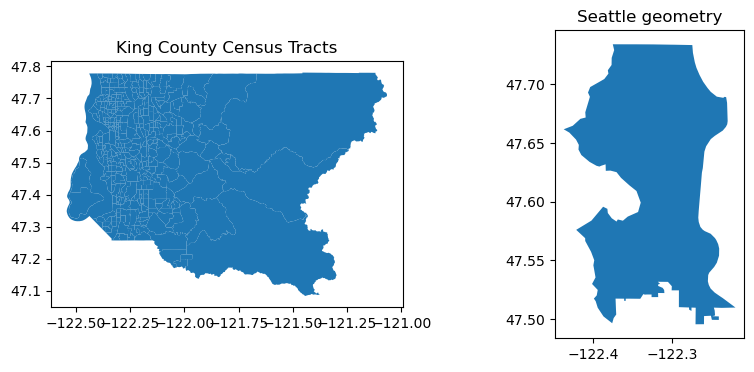

In [52]:
f,ax=plt.subplots(1,2,figsize=(10,4))

tract_geom_gdf.plot(ax=ax[0])
seattle_gdf.plot(ax=ax[1])

ax[0].set_title('King County Census Tracts')
ax[1].set_title('Seattle geometry')

#### *Combine the census data and census tract geometry and plot*
- You can try .join() to create a combined dataframe
    - what should you put for the "how" argument? 
- If it is not already, convert the dataframe into a geodataframe `census_kc_gdf`
    - What crs is the new geodataframe in? reproject it to EPSG:32610!
- Filter your new census_data_gdf by 'TotalPopulation' > 0 to get rid of empty tracts
- Make sure your Seattle geodataframe is also in EPSG:32610, then use the .clip() operation to create `census_sea_gdf`
- Create a figure with two total population choropleth plots, one for King County, and one for Seattle

In [53]:
# STUDENT CODE HERE

In [54]:
# STUDENT CODE HERE

In [55]:
# STUDENT CODE HERE

In [56]:
# STUDENT CODE HERE

In [57]:
# STUDENT CODE HERE

<img src="imgs/population_tracts.png" width="1000">

#### *Written response: Explore the map*
- Use geopandas .explore() on `census_kc_gdf` to explore the map
- Pass in a variable of interest to column
- Be mindful of your vmin and vmax settings!
- At submission time, please comment out this cell to reduce notebook size at turn in :)
- Tell us something you saw!

In [58]:
# STUDENT CODE HERE

**STUDENT WRITTEN RESPONSE HERE**

#### *Get a rough idea of variable correlation*
- Use the pandas built-in .corr() functionality and store the correlation matrix in census_corr
- Pass in numeric_only=True to avoid errors
- Pass in census_corr to sns.heatmap() to visualize the correlations

In [59]:
# STUDENT CODE HERE

In [60]:
# STUDENT CODE HERE

<img src="imgs/census_variable_correlation.png" width="1000">

#### *Written response: Try the variable correlation above for both `census_kc_gdf` and also `census_sea_gdf` What do you see?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Explore one of these relationships with a scatterplot*
- Try your own, don't copy the example!
- Besides plotting some variable on x and y, try setting the color/size of your points to another variable as well

In [61]:
# STUDENT CODE HERE

<img src="imgs/percent_non_white_vs_rented.png" width="1000">

#### *Written response: Describe an insight from the exploration of your plot!*

**STUDENT WRITTEN RESPONSE HERE**

## Part 7: Distribution of toxic releases in King County (4 pts)

- Let's explore how toxic releases are distributed across our census tracts. For this, let's use the Toxic Release Inventory (TRI)
- From the TRI website: **"TRI tracks the management of certain toxic chemicals that may pose a threat to human health and the environment. U.S. facilities in different industry sectors must report annually how much of each chemical is released to the environment and/or managed through recycling, energy recovery and treatment. (A "release" of a chemical means that it is emitted to the air or water, or placed in some type of land disposal.)"**
- TRI has all sorts of information for the US, but we are going to be focused on releases in King County
- Read more about the TRI here: https://www.epa.gov/toxics-release-inventory-tri-program/what-toxics-release-inventory

### Let's bring in the Toxic release data as a geodataframe in the correct crs
- For the sake of time, we've done done this for you and saved a geojson to the data folder.
- The code to do this is preserved below

In [62]:
# def get_tri_data(year=2019):
#     '''Get the Toxic Release Inventory data for a given year'''
#     url = f'https://data.epa.gov/efservice/downloads/tri/mv_tri_basic_download/{year}_US/csv'
#     columns_of_interest = ['2. TRIFD','4. FACILITY NAME','8. ST','23. INDUSTRY SECTOR','37. CHEMICAL','65. ON-SITE RELEASE TOTAL', '12. LATITUDE','13. LONGITUDE']
#     tri_data = pd.read_csv(url,usecols=columns_of_interest)
#     tri_data = pd.read_csv(url)
#     tri_data = tri_data[columns_of_interest]
#     tri_data.columns = tri_data.columns.str.replace('^[0-9. ]*', '', regex=True)
#     return tri_data

In [63]:
# tri_df = pd.DataFrame()

# for year in range(1987,2022):
#     tri_df = pd.concat([tri_df,get_tri_data(year)])
# tri_df

In [64]:
# tri_wa_df = tri_df[tri_df['ST'] == 'WA']
# tri_wa_df = tri_wa_df.reset_index(drop=True)
# tri_wa_gdf = gpd.GeoDataFrame(tri_wa_df, geometry=gpd.points_from_xy(tri_wa_df.LONGITUDE, tri_wa_df.LATITUDE)).set_crs('EPSG:4326').to_crs('EPSG:32610')
# tri_kc_gdf = gpd.sjoin(tri_wa_gdf, tract_geom_gdf.to_crs(32610), predicate="intersects")
# tri_kc_gdf = tri_kc_gdf.reset_index(drop=True)
# tri_kc_gdf = tri_kc_gdf.drop(columns='Tract')
# tri_kc_gdf.to_file("data/tri_kc.geojson", driver="GeoJSON")

In [65]:
# read in data
tri_kc_gdf = gpd.read_file('data/tri_kc.geojson')

### Clip locations to the convex hull of our census data
- Remember to do the unary_union before using convex hull!
- Hint: use intersects :)

In [66]:
# STUDENT CODE HERE

#### *Sort the geodataframe by `ON-SITE RELEASE TOTAL`*

In [67]:
# STUDENT CODE HERE

,TRIFD,FACILITY NAME,ST,INDUSTRY SECTOR,CHEMICAL,ON-SITE RELEASE TOTAL,LATITUDE,LONGITUDE,geometry
662,98106STTLS2414S,SEATTLE STEEL INC,WA,Primary Metals,Aluminum oxide (fibrous forms),2138500.0,47.569331,-122.367332,POINT (547585.548 5268628.876)
683,98108THBNG7500E,BOEING COMMERCIAL AIRPLANE GROUP NORTH BOEING ...,WA,Transportation Equipment,Trichloroethylene,682000.0,47.531169,-122.310812,POINT (551874.276 5264423.885)
774,98108RHNPL9229E,RHONE-POULENC INC,WA,Chemicals,Toluene,636166.0,47.520258,-122.303946,POINT (552401.934 5263215.89)
565,98108RHNPL9229E,RHONE-POULENC INC,WA,Chemicals,Toluene,570000.0,47.520258,-122.303946,POINT (552401.934 5263215.89)
1853,98002BNGCM70015,BOEING COMMERCIAL AIRPLANES - AUBURN,WA,Transportation Equipment,"1,1,1-Trichloroethane",570000.0,47.283625,-122.242770,POINT (557263.362 5236961.139)
...,...,...,...,...,...,...,...,...,...
5598,98032BRLNG20245,BURLINGTON ENVIRONMENTAL LLC,WA,Hazardous Waste,Nitrate compounds (water dissociable; reportab...,0.0,47.418259,-122.238184,POINT (557463.831 5251926.719)
7190,98032VNWTR8201S,UNIVAR SOLUTIONS KENT,WA,Chemical Wholesalers,Toluene,0.0,47.411106,-122.230700,POINT (558036.206 5251137.334)
7191,98032XTCMT5411S,EXOTIC METALS FORMING CO,WA,Transportation Equipment,Nickel compounds,0.0,47.399148,-122.264995,POINT (555461.544 5249783.393)
2320,98032MRCNN1220N,REXAM BEVERAGE CAN CO RE: KENT WA FACILITY,WA,Fabricated Metals,Nitric acid,0.0,47.404217,-122.238960,POINT (557420.559 5250365.608)


#### *Written response: What do you notice? What are the lowest values, and why do you think those are the lowest values?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Make a figure with two plots. On the left, the `ON-SITE RELEASE TOTAL` as points, and on the right, a hexbin plot of `release_count`.*
- Make the colorscale logarithmic

In [68]:
# STUDENT CODE HERE

<img src="imgs/onsight_releases_locations.png" width="1000">

#### *Plot the release sites on top of the median income census data*
- Now focus on Seattle: create `tri_sea_gdf` by clipping `tri_kc_gdf`
- Plot `tri_sea_gdf` on top of 'MedianIncome' from `census_sea_gdf`

In [69]:
# STUDENT CODE HERE

In [70]:
# STUDENT CODE HERE

<img src="imgs/release_sites_income.png" width="1000">

#### *Written response: What do you notice about the distribution of toxic releases as it relates to median income?*

**STUDENT WRITTEN RESPONSE HERE**

#### *Do a spatial join to get the census tract for each facility in Seattle*
- First buffer each facility by 100m
- Then join the facilities with the census tracts
- Find the total releases in pounds per tract (groupby tract, then sum)
- Find the total number of discrete release events per tract (groupby tract, then count)

In [71]:
tri_sea_gdf.loc[:,'geometry'] = tri_sea_gdf.buffer(100)

In [72]:
# STUDENT CODE HERE

In [73]:
census_sea_gdf['TRI_RELEASE_SUM'] = tri_sea_join_census_gdf.groupby('Tract')['ON-SITE RELEASE TOTAL'].sum().sort_index()
census_sea_gdf['TRI_RELEASE_SUM'] = census_sea_gdf['TRI_RELEASE_SUM'].fillna(0)

In [74]:
# STUDENT CODE HERE

#### *Create choropleth maps of Seattle: one for total on-site release (pounds), and one for number of discrete on-site release events*

In [75]:
# STUDENT CODE HERE

<img src="imgs/tri_by_tract.png" width="1000">

#### *Written response: Take a moment to reflect. What do you see?*

**STUDENT WRITTEN RESPONSE HERE**

## Submit your work

1. Save this notebook with all code and output (Make sure when you save the notebook, all cells show their outputs).
2. Use the terminal to stage, commit, and push your notebook to your GitHub repository. It should look something like this...
- git add 01_lab.ipynb
- git commit -m "Completed Lab 01 exercises"
- git push
3. Verify that your notebook appears in your GitHub repository. Double check to make sure all the ouputs are visible!